# Fully Connected Neural Network

In this example, we show how one can train a neural network on a specific task (here, Iris Classification) and use Concrete-Numpy to make the model work in FHE settings.

In [1]:
import numpy as np
import torch
from torch import nn

### Define our neural network

In [2]:
class FCIris(torch.nn.Module):
    """Neural network for Iris classification

    We define a fully connected network with three (3) fully connected (fc) layers that
    perform feature extraction and one (fc) layer to produce the final classification.
    We will use 3 neurons on all layers to ensure that the FHE accumulators
    do not overflow (we are currently only allowed a maximum of 7 bits-width).
    More information on this is available at
    https://docs.zama.ai/concrete-numpy/main/user/howto/reduce_needed_precision.html#limitations-for-fhe-friendly-neural-network.

    Due to accumulator limits, we have to design a network with only a few neurons on each layer.
    This is in contrast to a traditional approach where the number of neurons increases after
    each layer or block.
    """

    def __init__(self, input_size):
        super().__init__()

        # The first layer processes the input data, in our case 4 dimensional vectors
        self.linear1 = nn.Linear(input_size, 3)
        self.sigmoid1 = nn.Sigmoid()
        # Next, we add a one intermediate layer
        self.linear2 = nn.Linear(3, 3)
        self.sigmoid2 = nn.Sigmoid()
        # Finally, we add the decision layer for 3 output classes encoded as one-hot vectors
        self.decision = nn.Linear(3, 3)

    def forward(self, x):

        x = self.linear1(x)
        x = self.sigmoid1(x)
        x = self.linear2(x)
        x = self.sigmoid2(x)
        x = self.decision(x)

        return x

### Define all required variables to train the model

In [3]:
# Get iris dataset
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

# Split into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Initialize our model
model = FCIris(X.shape[1])

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Define the number of iterations
n_iters = 50001

# Define the batch size
batch_size = 16

### Train the model

In [4]:
def train():
    for i in range(n_iters):
        # Get a random batch of training data
        idx = torch.randperm(X_train.size()[0])
        X_batch = X_train[idx][:batch_size]
        y_batch = y_train[idx][:batch_size]

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        if i % 1000 == 0:
            # Print epoch number, loss and accuracy
            accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y_batch).item() / y_batch.size()[0]
            print(f"Iterations: {i:02} | Loss: {loss.item():.4f} | Accuracy: {100*accuracy:.2f}%")
            if accuracy == 1:
                break

## Compile the model

The `compile_torch_model` first applies a quantization to `model` with `n_bits` of precision using `X_train` as the calibration dataset and compile the model to its FHE counterparts. Here we use 3 bits of precision. In some edge cases, the network accumulators can overflow (i.e. extreme quantized values in both input and weights, which is unlikely). In such a case, we need to retrain the model.

In [5]:
from concrete.ml.torch.compile import compile_torch_model

print("Training a FHE friendly quantized network.")
for _ in range(10):
    try:
        train()
        print("Compiling the model to FHE.")
        quantized_compiled_module = compile_torch_model(
            model,
            X_train,
            n_bits=3,
        )
        print("The network is trained and FHE friendly.")
        break
    except RuntimeError as e:
        if str(e).startswith("max_bit_width of some nodes is too high"):
            print("The network is not fully FHE friendly, retraining.")
            continue
        raise e
else:
    raise RuntimeError(
        "Could not compile the model to FHE."
        "You may need to decrease the n_bits parameter to avoid potential overflows."
    )

Training a FHE friendly quantized network.
Iterations: 00 | Loss: 1.0572 | Accuracy: 25.00%
Iterations: 1000 | Loss: 0.3317 | Accuracy: 100.00%
Compiling the model to FHE.
The network is trained and FHE friendly.


### Predict with the torch model in clear

In [6]:
y_pred = model(X_test)

### Predict with the quantized model

In [7]:
# We now have a module in full numpy.
# Convert data to a numpy array.
X_train_numpy = X_train.numpy()
X_test_numpy = X_test.numpy()
y_train_numpy = y_train.numpy()
y_test_numpy = y_test.numpy()
q_X_test_numpy = quantized_compiled_module.quantize_input(X_test_numpy)
quant_model_predictions = quantized_compiled_module(q_X_test_numpy)

### Predict in FHE

In [8]:
from tqdm import tqdm

fhe_x_test = quantized_compiled_module.quantize_input(X_test_numpy)
homomorphic_quant_predictions = []
for x_q in tqdm(fhe_x_test):
    homomorphic_quant_predictions.append(
        quantized_compiled_module.forward_fhe.encrypt_run_decrypt(np.array([x_q]).astype(np.uint8))
    )
homomorphic_predictions = quantized_compiled_module.dequantize_output(
    np.array(homomorphic_quant_predictions, dtype=np.float32).reshape(quant_model_predictions.shape)
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [05:05<00:00,  8.05s/it]


### Print the accuracy of both models

In [9]:
acc_0 = 100 * (y_pred.argmax(1) == y_test).float().mean()
acc_1 = 100 * (quant_model_predictions.argmax(1) == y_test_numpy).mean()
acc_2 = 100 * (homomorphic_predictions.argmax(1) == y_test_numpy).mean()

print(f"Test Accuracy: {acc_0:.2f}%")
print(f"Test Accuracy Quantized Inference: {acc_1:.2f}%")
print(f"Test Accuracy Homomorphic Inference: {acc_2:.2f}%")

Test Accuracy: 97.37%
Test Accuracy Quantized Inference: 65.79%
Test Accuracy Homomorphic Inference: 68.42%


<Figure size 432x288 with 0 Axes>

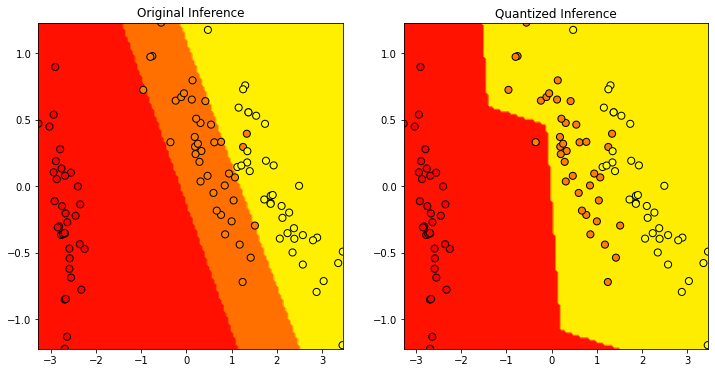

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_numpy)

b_min = np.min(X_train_2d, axis=0)
b_max = np.max(X_train_2d, axis=0)

grid_dims = tuple(np.linspace(b_min[i], b_max[i], 128) for i in range(X_train_2d.shape[1]))
ndgrid_tuple = np.meshgrid(*grid_dims)
grid_2d = np.vstack([g.ravel() for g in ndgrid_tuple]).transpose()

grid_test = pca.inverse_transform(grid_2d)
grid_test_quantized = quantized_compiled_module.quantize_input(grid_test)

grid_pred_all = quantized_compiled_module(grid_test_quantized)
grid_pred_all_original = model(torch.tensor(grid_test).float()).detach().numpy()

pred_classes = np.argmax(grid_pred_all, axis=1).astype(np.int32)
pred_classes_original = np.argmax(grid_pred_all_original, axis=1).astype(np.int32)

%matplotlib inline

from matplotlib import pyplot as plt

cmap = "autumn"
# Create two subplots and set their locations
plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot original model contour plot
axs[0].contourf(
    ndgrid_tuple[0],
    ndgrid_tuple[1],
    pred_classes_original.reshape(ndgrid_tuple[0].shape),
    cmap=cmap,
)

# Plot the scatter with marker borders
axs[0].scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_numpy, s=50, edgecolors="k", cmap=cmap)

# Add title and axis labels
axs[0].set_title("Original Inference")


# Plot quantized model contour plot
axs[1].contourf(
    ndgrid_tuple[0], ndgrid_tuple[1], pred_classes.reshape(ndgrid_tuple[0].shape), cmap=cmap
)

# Plot the scatter with marker borders
axs[1].scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_numpy, s=50, edgecolors="k", cmap=cmap)

# Add title and axis labels
axs[1].set_title("Quantized Inference")


plt.show()

In the above plot, we show the decision boundaries for both the original and quantized model. The quantized model has it's decision boundaries (colored regions) slightly shifted compared to the original model. This is due to the low-bit quantization applied to the model in post-training.

Here we do not compute the contour plot for the FHE inference as this would be really costly but it should be pretty close to the quantized model.  

## Summary

In this notebook, we presented a few steps to have a model (torch neural network) inference in over homomorphically encrypted data: 
- We first trained a fully connected neural network yielding ~97% accuracy
- Then, we quantized it using Concrete-Numpy. We observed a small decrease in accuracy here due to the strong quantization applied(accuracy = ~94%).
- We then used the compiled inference into its FHE equivalent to get our FHE predictions over the test set

The homomorphic inference achieves a similar accuracy as the quantized model inference.

Disclaimer: post-training quantization with such a low bit width (<=3) can yield different results for the quantized model which will mainly depend on the range of the learned weights.